# Feature importance method in sci-kit learn

We'll get a sense of how feature importance is calculated in sci-kit learn, and also see where it gives results that we wouldn't expect.

Sci-kit learn uses gini impurity to calculate a measure of impurity for each node.  Gini impurity, like entropy is a way to measure how "disorganized" the observations are before and after splitting them using a feature. So there is an impurity measure for each node.

In the formula, freq_{i} is the frequency of label "i".  C is the number of unique labels at that node.

$Impurity= \sum_{i=1}^{C} - freq_{i} * (1- freq_{i})$

The node importance in sci-kit learn is calculated as the difference between the gini impurity of the node and the gini impurity of its left and right children.  These gini impurities are weighted by the number of data points that reach each node.

$NodeImportance = w_{i} Impurity_{i} - ( w_{left} Impurity_{left} + w_{right} Impurity_{right} )$

The importance of a feature is the importance of the node that it was split on, divided by the sum of all node importances in the tree.  You’ll get to practice this in the coding exercise coming up next!

For additional reading, please check out this blog post [The Mathematics of Decision Trees, Random Forest and Feature Importance in Scikit-learn and Spark](https://medium.com/@srnghn/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3)

In [ ]:
import sys
!{sys.executable} -m pip install numpy==1.14.5
!{sys.executable} -m pip install scikit-learn==0.19.1
!{sys.executable} -m pip install graphviz==0.9

In [1]:
import sklearn
from sklearn import tree
import numpy as np
import graphviz

## Generate data

We'll generate features and labels that form the "AND" operator.  So when feature 0 and feature 1 are both 1, then the label is 1, else the label is 0.  The third feature, feature 2, won't have an effect on the label output (it's always zero).

In [2]:
"""
Features 0 and 1 form the AND operator
Feature 2 is always zero.
"""
N = 100
M = 3
X = np.zeros((N,M))
X.shape
y = np.zeros(N)
X[:1 * N//4, 1] = 1
X[:N//2, 0] = 1
X[N//2:3 * N//4, 1] = 1
y[:1 * N//4] = 1

In [4]:
# observe the features
X.shape

(100, 3)

In [6]:
# observe the labels
y.shape

(100,)

## Train a decision tree

In [7]:
model = tree.DecisionTreeClassifier(random_state=0)
model.fit(X, y)

DecisionTreeClassifier(random_state=0)

## Visualize the trained decision tree

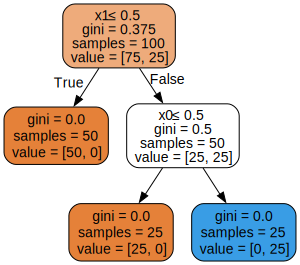

In [8]:
dot_data = sklearn.tree.export_graphviz(model, out_file=None, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## Explore the tree

The [source code for Tree](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_tree.pyx) has useful comments about attributes in the Tree class.  Search for the code that says `cdef class Tree:` for useful comments.

In [10]:
# get the Tree object
tree0 = model.tree_
print(tree0)

## Tree attributes are stored in lists

The tree data are stored in lists.  Each node is also assigned an integer 0,1,2...  
Each node's value for some attribute is stored at the index location that equals the node's assigned integer.

For example, node 0 is the root node at the top of the tree.  There is a list called children_left.  Index location 0 contains the left child of node 0.


#### left and right child nodes
```
children_left : array of int, shape [node_count]
        children_left[i] holds the node id of the left child of node i.
        For leaves, children_left[i] == TREE_LEAF. Otherwise,
        children_left[i] > i. This child handles the case where
        X[:, feature[i]] <= threshold[i].
children_right : array of int, shape [node_count]
        children_right[i] holds the node id of the right child of node i.
        For leaves, children_right[i] == TREE_LEAF. Otherwise,
        children_right[i] > i. This child handles the case where
        X[:, feature[i]] > threshold[i].
```

In [11]:
print(f"tree0.children_left: {tree0.children_left}")
print(f"tree0.children_right: {tree0.children_right}")

tree0.children_left: [ 1 -1  3 -1 -1]
tree0.children_right: [ 2 -1  4 -1 -1]


So in this tree, the index positions 0,1,2,3,4 are the numbers for identifying each node in the tree.  Node 0 is the root node.  Node 1 and 2 are the left and right child of the root node.  So in the list children_left, at index 0, we see 1, and for children_right list, at index 0, we see 2.  

-1 is used to denote that there is no child for that node.  Node 1 has no left or right child, so in the children_left list, at index 1, we see -1.  Similarly, in children_right, at index 1, the value is also -1.

#### features used for splitting at each node
```
    feature : array of int, shape [node_count]
        feature[i] holds the feature to split on, for the internal node i.
```

In [12]:
print(f"tree0.feature: {tree0.feature}")

tree0.feature: [ 1 -2  0 -2 -2]


The feature 1 is used to split on node 0.  Feature 0 is used to split on node 2.  The -2 values indicate that these are leaf nodes (no features are used for splitting at those nodes).

#### number of samples in each node

```
n_node_samples : array of int, shape [node_count]
        n_node_samples[i] holds the number of training samples reaching node i.

weighted_n_node_samples : array of int, shape [node_count]
        weighted_n_node_samples[i] holds the weighted number of training samples
        reaching node i.
```

In [13]:
print(f"tree0.n_node_samples : {tree0.n_node_samples}")
print(f"tree0.weighted_n_node_samples : {tree0.weighted_n_node_samples}")

tree0.n_node_samples : [100  50  50  25  25]
tree0.weighted_n_node_samples : [100.  50.  50.  25.  25.]


The weighted_n_node_samples is the same as n_node_samples for decision trees.  It's different for random forests where a sub-sample of data points is used in each tree.  We'll use weighted_n_node_samples in the code below, but either one works when we're calculating the proportion of samples in a left or right child node relative to their parent node.

## Gini impurity

Gini impurity, like entropy is a way to measure how "disorganized" the observations are before and after splitting them using a feature. So there is an impurity value calculated for each node.

In the formula, $freq_{i}$ is the frequency of label "i".  C is the number of unique labels at that node (C stands for "Class", as in "classifier".

$ \sum_{i}^{C} - freq_{i} * (1- freq_{i})$

```
impurity : array of double, shape [node_count]
        impurity[i] holds the impurity (i.e., the value of the splitting
        criterion) at node i.

```

What is the impurity if there is a single class (unique label type)?

In [14]:
freq0 = 1
impurity = -1 * freq0 * (1 - freq0)
print(f"impurity of a homogenous sample with a single label, is: {impurity}")

impurity of a homogenous sample with a single label, is: 0


What is the impurity if there are two classes (two distinct labels), and there are 90% of samples for one label, and 10% for the other?

In [15]:
freq1 = 0.9
freq2 = 0.1
impurity = -1 * freq1 * (1 -freq1) + -1 * freq2 * (1 - freq2)
print(f"impurity when 90% are of one label, and 10% are of the other: {impurity}")

impurity when 90% are of one label, and 10% are of the other: -0.18


## Quiz
What is the impurity if there are two classes of label, and there are 50% of samples for one label, and 50% for the other?

In [16]:
"""
What is the impurity if there are two classes of label,
and there are 50% of samples for one label, and 50% for the other?
"""
# TODO
freq1 = 0.5
freq2 = 0.5
# TODO
impurity = -freq1 * (1-freq1) - freq2 * (1-freq2)
print(f"impurity when 50% are of one label, and 50% are of the other: {impurity}")

impurity when 50% are of one label, and 50% are of the other: -0.5


## Quiz

Is the impurity larger or smaller (in magnitude) when the samples are dominated by a single class?  Smaller

Is the impurity larger or smaller (in magnitude) when the frequency of each class is more evenly distributed among classes? Larger

## Answer


## Node Importance

The node importance in sklearn is calculated as the difference between the gini impurity of the node and the impurities of its child nodes.  These gini impurities are weighted by the number of data points that reach each node.

$NodeImportance = w_{i} Impurity_{i} - ( w_{left} Impurity_{left} + w_{right} Impurity_{right} )$


#### Summary of the node labels
Node 0 is the root node, and its left and right children are 1 and 2.  
Node 1 is a leaf node  
Node 2 has two children, 3 and 4.  
Node 3 is a leaf node  
Node 4 is a leaf node  

In [17]:
# summary of child nodes
print(f"tree0.children_left: {tree0.children_left}")
print(f"tree0.children_right: {tree0.children_right}")

tree0.children_left: [ 1 -1  3 -1 -1]
tree0.children_right: [ 2 -1  4 -1 -1]


Calculate the node importance of the root node, node 0.  Its child nodes are 1 and 2

In [18]:
ni0 = tree0.weighted_n_node_samples[0] * tree0.impurity[0] - \
        ( tree0.weighted_n_node_samples[1] * tree0.impurity[1] + \
          tree0.weighted_n_node_samples[2] * tree0.impurity[2] )
print(f"Importance of node 0 is {ni0}")

Importance of node 0 is 12.5


## Quiz
Calculate the node importance of node 2.  Its left and right child nodes are 3 and 4

In [26]:
# TODO
ni2 = tree0.weighted_n_node_samples[2] * tree0.impurity[2] - \
        ( tree0.weighted_n_node_samples[3] * tree0.impurity[3] + \
          tree0.weighted_n_node_samples[4] * tree0.impurity[4] )
print(f"Importance of node 2 is {ni2}")

Importance of node 2 is 25.0


The other nodes are leaf nodes, so there is no decrease in impurity that we can calculate

#### Sum the node importances
Only nodes 0 and node 2 have node importances.  The others are leaf nodes, so we don't calculate node importances (there is no feature that is used for splitting at those leaf nodes).

In [27]:
# TODO
ni_total = ni0 + ni2
print(f"The sum of node importances is {ni_total}")

The sum of node importances is 37.5


#### Summary of which feature is used to split at each node

feature 0 was used to split on node 2  
feature 1 was used to split on node 0  
feature 2 was not used for splitting

In [28]:
print(f"tree0.feature: {tree0.feature}")

tree0.feature: [ 1 -2  0 -2 -2]


## Quiz: Calculate importance of the features

The importance of a feature is the importance of the node that it was used for splitting, divided by the total node importances.  Calculate the importance of feature 0, 1 and 2.

In [31]:
# TODO
fi0 = ni2 / ni_total
fi1 = ni0 / ni_total
fi2 = 0
print(f"importance of feature 0: {fi0}")
print(f"importance of feature 1: {fi1}")
print(f"importance of feature 2: {fi2}")

importance of feature 0: 0.6666666666666666
importance of feature 1: 0.3333333333333333
importance of feature 2: 0


## Double check with sklearn

Check out how to use [feature importance](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_)

In [32]:
# TODO: get feature importances from sci-kit learn

fi0_skl = model.feature_importances_[0]
fi1_skl = model.feature_importances_[1]
fi2_skl = model.feature_importances_[2]

print(f"sklearn importance of feature 0: {fi0_skl}")
print(f"sklearn importance of feature 1: {fi1_skl}")
print(f"sklearn importance of feature 2: {fi2_skl}")

sklearn importance of feature 0: 0.6666666666666666
sklearn importance of feature 1: 0.3333333333333333
sklearn importance of feature 2: 0.0


## Notice anything odd?

Notice that the data we generated simulates an AND operator.  If feature 0 and feature 1 are both 1, then the output is 1, otherwise 0.  So, from that perspective, do you think that features 0 and 1 are equally important?

What do you notice about the feature importance calculated in sklearn?  Are the features considered equally important according to this calculation?

### Answer


## Question

If someone tells you that you don't need to understand the algorithm, just how to install the package and call the function, do you agree or disagree with that statement?

## Solution notebook
[Solution notebook](sklearn_feature_importance_solution.ipynb)